In [62]:
import cv2 as cv
import pandas as pd
import numpy as np


def get_components(image):
    """Get the individual connected components of an image

    Returns:
        tuple (labeled_image, coordinates, components)
    """

    processed = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    processed = cv.threshold(processed, 0, 1, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    _, img, stats, _ = cv.connectedComponentsWithStats(processed)
    coords = pd.DataFrame(
        stats[
            :,
            [
                cv.CC_STAT_LEFT,
                cv.CC_STAT_TOP,
                cv.CC_STAT_WIDTH,
                cv.CC_STAT_HEIGHT,
            ],
        ],
        columns=["x", "y", "w", "h"],
    )
    coords["x2"] = coords.x + coords.w
    coords["y2"] = coords.y + coords.h

    return (
        img,
        coords,
        [processed[r.y : r.y2, r.x : r.x2] for _, r in coords.iterrows()],
    )

In [63]:
get_components(cv.imread("twinkle2.jpg"))

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
        x     y     w     h    x2    y2
 0      0     0  1000  1414  1000  1414
 1    436    85     6    30   442   115
 2    460    86    29    27   489   113
 3    494    86    29    28   523   114
 4    447    93     9    14   456   107
 ..   ...   ...   ...   ...   ...   ...
 148  669  1226     9    16   678  1242
 149  751  1226    10    16   761  1242
 150  822  1226     9    16   831  1242
 151  356  1232    15     4   371  1236
 152  471  1399     4    14   475  1413
 
 [153 rows x 6 columns],
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, 1, 1, 1],
     

In [64]:
def generate_components(write: bool = False):
    from pathlib import Path

    Path("components/").mkdir(exist_ok=True)

    filtered = []

    i = 0
    for img in Path("scores/").iterdir():
        components = get_components(cv.imread(str(img.resolve())))
        for component in components[2]:
            if component.shape[0] * component.shape[1] > 40_000:
                continue  # component too large

            filtered.append(component)

            if not write:
                continue

            cv.imwrite(str(Path("components") / f"{i}.jpg"), component * 255)
            i += 1
            if i % 50 == 0:
                print(i)

    return filtered

Text(0.5, 1.0, "Similarities from 'F'")

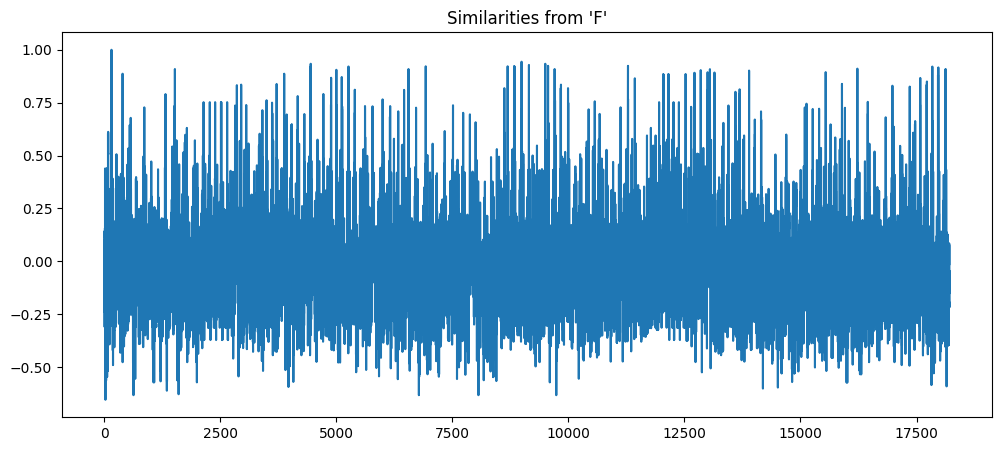

In [65]:
ref = cv.imread("categorized/156.jpg")  # "F" as in a chord
ref = cv.cvtColor(ref, cv.COLOR_BGR2GRAY)
ref = cv.threshold(ref, 0, 1, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
ref = ref.astype("float32")  # switch to float for better resizing, etc.

components = generate_components()
similarities = np.empty(len(components))
for i, component in enumerate(components):
    dimensions = (
        max(
            ref.shape[1], component.shape[1]
        ),  # maximum dimensions to avoid compression and data loss
        max(ref.shape[0], component.shape[0]),
    )
    resized = cv.resize(
        component.astype("float32"),
        dimensions,
        interpolation=cv.INTER_CUBIC,
    )
    resized_ref = cv.resize(
        ref,
        dimensions,
        interpolation=cv.INTER_CUBIC,
    )
    similarity = cv.matchTemplate(resized, resized_ref, cv.TM_CCOEFF_NORMED).item()

    similarities[i] = similarity

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(similarities)
plt.title("Similarities from 'F'")

In [66]:
def compare(source, target, method: int = cv.TM_CCOEFF_NORMED):
    aspect_ratios = (
        source.shape[1] / target.shape[1],
        source.shape[0] / target.shape[0],
    )
    coef = (
        min(aspect_ratios) / max(aspect_ratios)
    ) ** 2  # penalize large differences in aspect ratio

    source, target = resize(source, target)

    return cv.matchTemplate(source, target, method=method).item() * coef


def resize(source, target):
    dimensions = (
        max(
            source.shape[1], target.shape[1]
        ),  # maximum dimensions to avoid compression and data loss
        max(source.shape[0], target.shape[0]),
    )
    source = cv.resize(
        source.astype("float32"),
        dimensions,
        interpolation=cv.INTER_CUBIC,
    )
    target = cv.resize(
        target.astype("float32"),
        dimensions,
        interpolation=cv.INTER_CUBIC,
    )

    return source, target

In [67]:
def compare_batch(sources, target, method: int = cv.TM_CCOEFF_NORMED):
    similarities = np.empty(len(sources), dtype="float32")
    for i, source in enumerate(sources):
        similarities[i] = compare(source, target, method=method)

    return similarities

In [68]:
# compare different thresholds
if False:
    for thres in np.linspace(0.75, 0.95, 21):
        for i, idx in enumerate(np.arange(len(components))[similarities > thres]):
            if i % 36 == 0:
                fig, axs = plt.subplots(6, 6, figsize=(12, 12))
            fig.suptitle(f"{thres=:.2f}")
            j = i % 36
            axs[j // 6, j % 6].imshow(components[idx], cmap="gray_r")
            fig.tight_layout()

TM_CCOEFF_NORMED
TM_CCOEFF
TM_CCORR_NORMED
TM_CCORR
TM_SQDIFF_NORMED
TM_SQDIFF


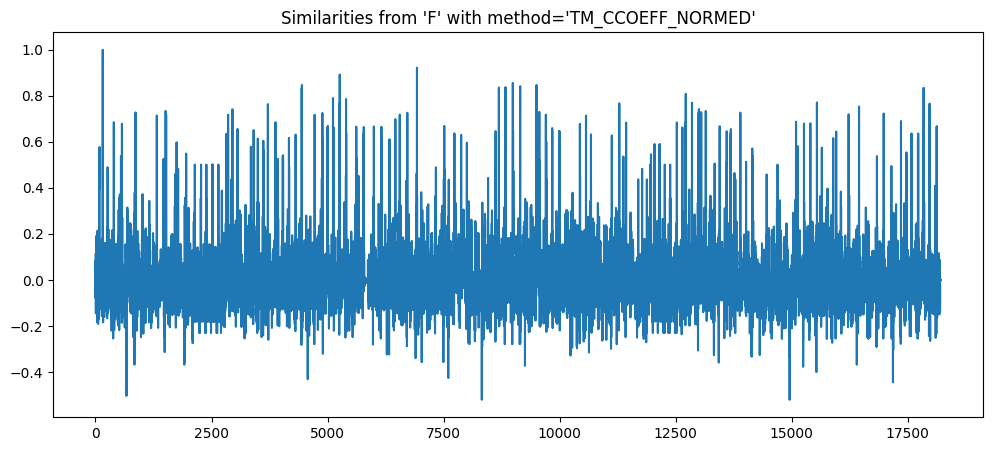

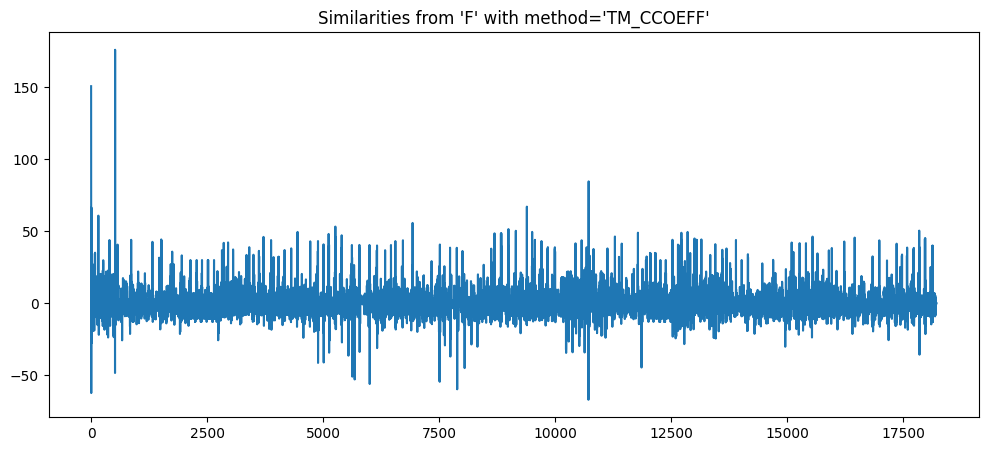

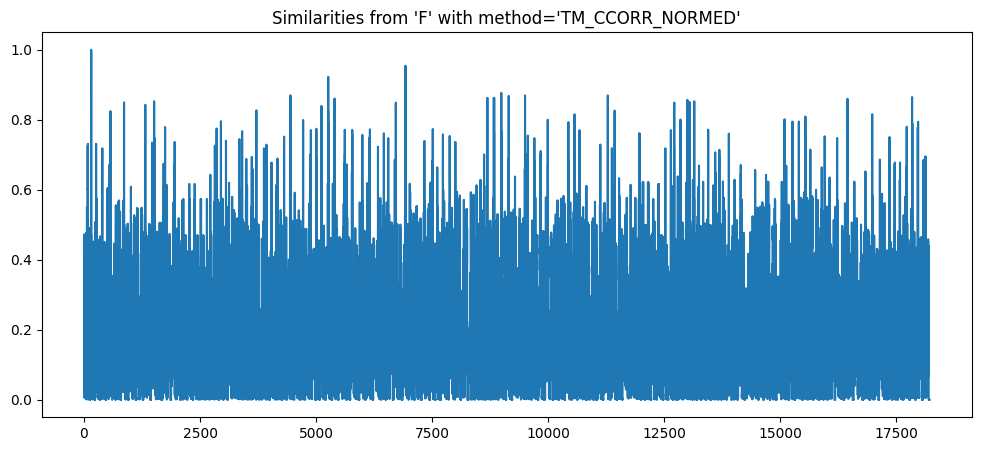

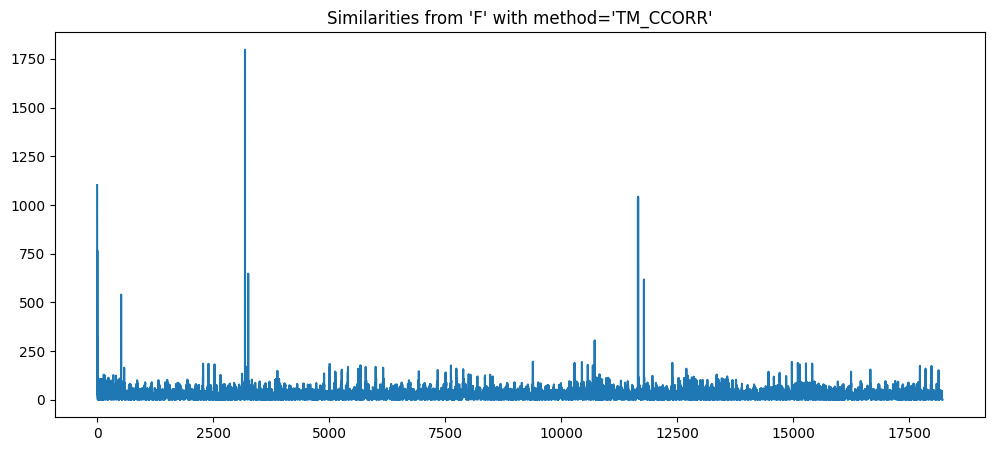

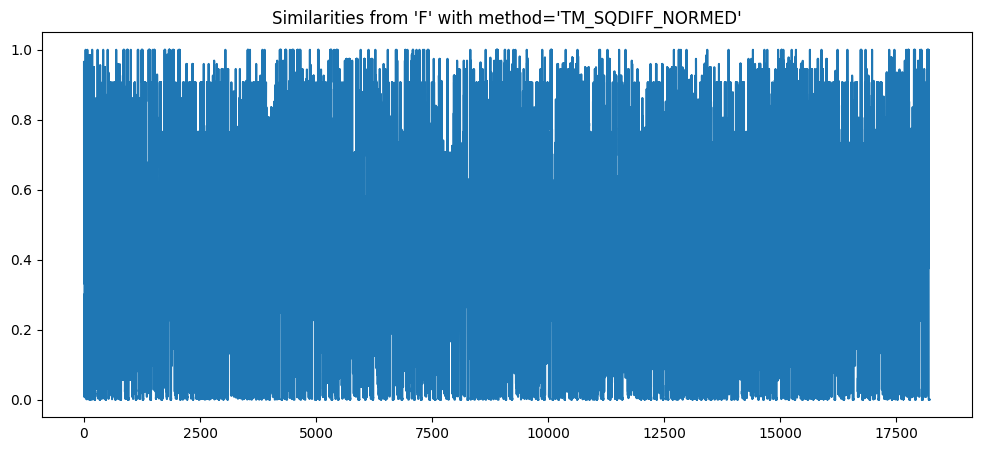

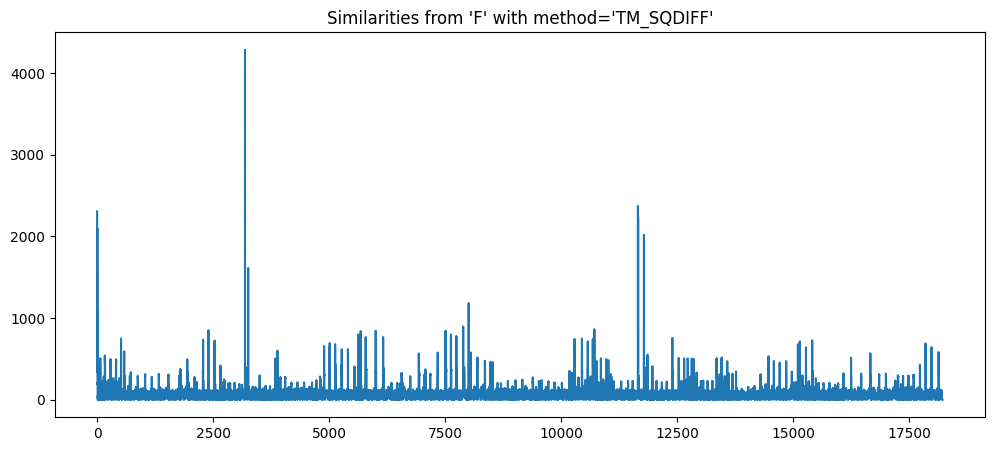

In [69]:
methods = [
    "TM_CCOEFF_NORMED",
    "TM_CCOEFF",
    "TM_CCORR_NORMED",
    "TM_CCORR",
    "TM_SQDIFF_NORMED",
    "TM_SQDIFF",
]

components = generate_components()
for method in methods:
    print(method)
    method_val: int = getattr(cv, method)
    similarities = compare_batch(components, ref, method=method_val)
    plt.figure(figsize=(12, 5))
    plt.plot(similarities)
    plt.title(f"Similarities from 'F' with {method=}")

    continue
    print(len(np.arange(len(components))[similarities > 0.80]))
    for i, idx in enumerate(np.arange(len(components))[similarities > 0.80]):
        if i % 36 == 0:
            fig, axs = plt.subplots(6, 6, figsize=(12, 12))
        fig.suptitle(f"Filtered 'F's for {method=}")
        j = i % 36
        axs[j // 6, j % 6].imshow(components[idx], cmap="gray_r")
        fig.tight_layout()

In [70]:
from pathlib import Path


def generate_similarities(components, categories: list):
    similarities = np.stack(
        [compare_batch(components, category) for category in categories]
    )

    return similarities


def classify_components(components, categories: list):
    similarities = generate_similarities(components, categories)
    return similarities.argmax(axis=0)

In [71]:
def read_category(path: Path):
    image = cv.imread(str(path))
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.threshold(image, 0, 1, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    return image


categories = [read_category(path.resolve()) for path in Path("categorized/").iterdir()]
components = generate_components()
similarities = generate_similarities(components, categories)
results = similarities.argmax(axis=0)

In [72]:
Path("classes.txt").write_text(str(list(results)))

69525

In [74]:
def compare_component_category(component_idx, category_idx):
    component, category = resize(components[component_idx], categories[category_idx])
    print(component.shape, category.shape)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(components[component_idx], cmap="gray_r")
    axs[1].imshow(categories[category_idx], cmap="gray_r")
    similarity = compare(components[component_idx], categories[category_idx])
    print(f"Similarity: {similarity}")

[]
(17, 16) (17, 16)
Similarity: 0.0002876271191214221


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

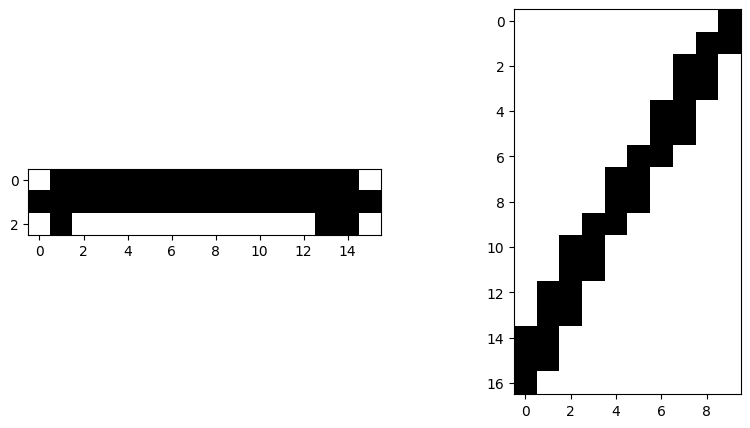

In [76]:
indices = []

count = 0
for i in range(len(results)):
    if results[i] == 3:
        count += 1
        if count == 5:
            indices.append(i - 4)
            count = 0
    else:
        count = 0

print(indices)

compare_component_category(680, 3)
components[678]

In [77]:
similarities[:, 126].T

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.5290658e-01,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       3.8292814e-07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [78]:
similarities[:, 40].T.argmax()

33

In [83]:
categories = [path.resolve() for path in Path("categorized/").iterdir()]
categories[39]

PosixPath('/workspaces/nmn-dataset/notebooks/categorized/678.jpg')